# 美团火锅美食店铺评论分析

本文

In [130]:
#引入库
import pandas as pd
from matplotlib import pyplot as plt
import pymysql
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import time
import jieba

In [107]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')

## 1. 读取数据
将之前爬取的美团评论数据载入进去，有两种方式：
* 直接连接数据库，将数据载入到文件中
* 将数据从数据库下载下来，再导入

我们使用第二种方式， pd.read_excel()函数载入数据

In [3]:
data = pd.read_excel('meituan.xlsx')

In [4]:
#载入数据较慢，建议建立副本
meituan = data.copy()

In [6]:
meituan.head()

,评论店铺,评论用户姓名,评论用户id,评论用户星级,评论用户菜品,评论用户内容,评论时间
0,158743609,养了四条鱼,156107390,50,男票甜蜜双人餐，提供免费WiFi,「#套餐：男票甜蜜双人餐」\n今天休息，团了个男票的火锅双人券，真划算啊。\n去得早，没排队...,1630763461703
1,158743609,养了四条鱼,156107390,50,真爱虾滑1份，包间免费,「#套餐：真爱虾滑」\n好久没吃火锅了，也没逛江汉路了，嗯，疫情的错。最近好像人都出来了，那...,1630763236546
2,158743609,ddddddeft,1792254311,45,男票经典双人餐，提供免费WiFi,【口味】味道真的不错，价格也很实惠。朋友推荐去吃的。今天还是比较幸运的，去了没有排队，坐下之...,1630634710594
3,158743609,Yoogut,1479967201,45,50元代金券1张，可叠加3张,本来和朋友一起去吃自助的，不知道怎么莫名其妙跑去女人大世界做美甲了，可气死我了。然后她有优惠...,1629042279263
4,158743609,浪诗的浪潮,1954780805,50,男票经典双人餐，提供免费WiFi,「#套餐：男票经典双人餐」\n七夕出来吃火锅，团购的券刚好用上\n「#经典肥牛卷」嫩趴趴的，...,1629197745111


## 2. 数据概要

In [7]:
meituan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42038 entries, 0 to 42037
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   评论店铺    42038 non-null  int64 
 1   评论用户姓名  42036 non-null  object
 2   评论用户id  42038 non-null  int64 
 3   评论用户星级  42038 non-null  int64 
 4   评论用户菜品  33939 non-null  object
 5   评论用户内容  23759 non-null  object
 6   评论时间    42038 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.2+ MB


In [8]:
data.shape

(42038, 7)

## 3. 数据清洗

### 3.1 处理缺失值

根据上节的分析，发现数据中存在大量的缺失值，首先先对缺失值进行处理，缺失值处理的方式主要有以下几种：
* 填补缺失值，可以用均值、中位数、众数进行填补，适用于缺失值不是很明显的
* 删除缺失值，将这一行记录进行删除，适用于缺失值较多的指标

我们发现我们的数据 **评论用户姓名** 存在两个缺失值，**评论用户菜品** 和 **评论用户内容** 缺失值较多，相对来说 **评论用户内容** 属于我们的核心属性，并且是文本数据，无法进行填补，因此首先对这一维度的指标进行删除缺失值处理

In [16]:
meituan = meituan[~meituan['评论用户内容'].isnull()]

In [21]:
meituan.isnull().sum()

评论店铺         0
评论用户姓名       0
评论用户id       0
评论用户星级       0
评论用户菜品    4778
评论用户内容       0
评论时间         0
dtype: int64

### 3.2 时间数据转化

我们发现 **评论时间** 这一属性是属于时间戳类型，也就是将日期转化成一串数字，因为需要将这一列属性转化为日期类型

这个相对比较复杂，一般来说有 10位的时间戳是精确到秒的，13位的时间戳是精确到毫秒的，这两种时间戳转化的方式不一样，具体下面这样的：
* 13位的时间戳利用函数 time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(millis/1000))
* 10位的时间戳利用函数 time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(millis))

**因此我们直接对这一属性运用隐函数进行实现**

In [38]:
meituan['评论时间'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x/1000)))

0        2021-09-04 21:51:01
1        2021-09-04 21:47:16
2        2021-09-03 10:05:10
3        2021-08-15 23:44:39
4        2021-08-17 18:55:45
                ...         
42020    2021-03-27 13:39:19
42021    2021-03-14 14:37:42
42022    2021-03-14 10:56:54
42023    2021-03-14 10:56:02
42024    2021-03-14 17:08:49
Name: 评论时间, Length: 23759, dtype: object

In [39]:
#接着将上述这一列应用到数据上
meituan['评论时间'] = meituan['评论时间'].apply(lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x/1000)))

d:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


紧接着从时间属性中提取到年、月、日、星期、小时的属性

In [60]:
meituan['评论时间'] = pd.to_datetime(meituan['评论时间'])
meituan['评论年份'] = meituan['评论时间'].dt.year
meituan['评论月份'] = meituan['评论时间'].dt.month
meituan['评论星期'] = meituan['评论时间'].dt.weekday
meituan['评论小时'] = meituan['评论时间'].dt.hour

d:\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
d:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\python\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [62]:
meituan.drop('评论时间', axis=1, inplace=True)

d:\python\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### 3.3 文本内容处理
发现文本数据中存在大量的空格，这完全不利于分析处理，因此将空格进行删除

In [66]:
#首先利用 strip() 函数删除数据前后的空格
meituan['评论用户内容'] = meituan['评论用户内容'].str.strip()

d:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [68]:
#其次利用隐函数删除文本中的空格 换行符
# 正则中 /s 代表匹配任何空白字符，包括空格、制表符、换页符等等。等价于 [ \f\n\r\t\v]。注意 Unicode 正则表达式会匹配全角空格符。
meituan['评论用户内容'].replace('\s+','',regex=True,inplace=True)

d:\python\lib\site-packages\pandas\core\series.py:4512: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [70]:
meituan.head()

,评论店铺,评论用户姓名,评论用户id,评论用户星级,评论用户菜品,评论用户内容,评论年份,评论月份,评论星期,评论小时
0,158743609,养了四条鱼,156107390,50,男票甜蜜双人餐，提供免费WiFi,「#套餐：男票甜蜜双人餐」今天休息，团了个男票的火锅双人券，真划算啊。去得早，没排队，还选了...,2021,9,5,21
1,158743609,养了四条鱼,156107390,50,真爱虾滑1份，包间免费,「#套餐：真爱虾滑」好久没吃火锅了，也没逛江汉路了，嗯，疫情的错。最近好像人都出来了，那必须...,2021,9,5,21
2,158743609,ddddddeft,1792254311,45,男票经典双人餐，提供免费WiFi,【口味】味道真的不错，价格也很实惠。朋友推荐去吃的。今天还是比较幸运的，去了没有排队，坐下之...,2021,9,4,10
3,158743609,Yoogut,1479967201,45,50元代金券1张，可叠加3张,本来和朋友一起去吃自助的，不知道怎么莫名其妙跑去女人大世界做美甲了，可气死我了。然后她有优惠...,2021,8,6,23
4,158743609,浪诗的浪潮,1954780805,50,男票经典双人餐，提供免费WiFi,「#套餐：男票经典双人餐」七夕出来吃火锅，团购的券刚好用上「#经典肥牛卷」嫩趴趴的，跟平常那...,2021,8,1,18


### 3.5 删除重复值

由于爬虫的数据可能出现重复采集的情况，或者某个人多次评论，导致出现很多无效数据，因此需要重复的数据删除

In [90]:
# 判断重复的条件是所有列的数据完全一样才是重复数据
meituan.duplicated(subset=None)

0        False
1        False
2        False
3        False
4        False
         ...  
42020     True
42021     True
42022     True
42023     True
42024     True
Length: 23759, dtype: bool

In [91]:
# 上面看的不是很清楚，利用下面代码可以具体看清楚
meituan[meituan.duplicated(subset=None, keep=False) == True]

,评论店铺,评论用户姓名,评论用户id,评论用户星级,评论用户菜品,评论用户内容,评论年份,评论月份,评论星期,评论小时
1866,158743609,好多多多的鱼,282531333,50,男票甜蜜双人餐，提供免费WiFi,环境不错，服务员服务很热情，价格划算，味道好吃，下次还和朋友一起来哈哈,2019,10,4,20
1867,158743609,好多多多的鱼,282531333,50,男票甜蜜双人餐，提供免费WiFi,环境不错，服务员服务很热情，价格划算，味道好吃，下次还和朋友一起来哈哈,2019,10,4,20
2004,158743609,匿名用户,0,20,50元代金券1张，可叠加,服务态度还不错，就是味道很一般呢,2019,8,4,11
2005,158743609,匿名用户,0,20,50元代金券1张，可叠加,服务态度还不错，就是味道很一般呢,2019,8,4,11
10621,179398779,璀璨龙,264770980,50,来了都是大咖，建议3-4人使用,不错,2020,8,5,17
...,...,...,...,...,...,...,...,...,...,...
42020,545136114,可期748,2938753758,50,特惠双人套餐，包间免费,老板人超级好，菜也很实惠,2021,3,5,13
42021,545136114,高文静412,408547728,50,特惠双人套餐，包间免费,味道还蛮不错的，就是位置有点偏，章鱼小丸子推荐,2021,3,6,14
42022,545136114,TGD773813609,880739861,50,酸梅汤1杯，包间免费,环境好，超值划算，味道不错,2021,3,6,10
42023,545136114,TGD773813609,880739861,50,特惠双人套餐，包间免费,很划算，超值！环境也不错下次还来,2021,3,6,10


In [97]:
# 上述说明确实有重复值，将数据进行删除处理
meituan = meituan.drop_duplicates()

## 4. 指标分析
上述的数据清洗已经完成，接着对数据的指标进行处理分析

首先查看一下用户评级的分布情况

[Text(0, 0, '744012'),
 Text(1, 0, '2429873'),
 Text(2, 0, '4134768'),
 Text(3, 0, '4871666'),
 Text(4, 0, '5151532'),
 Text(5, 0, '76875267'),
 Text(6, 0, '79437796'),
 Text(7, 0, '99971655'),
 Text(8, 0, '154922490'),
 Text(9, 0, '158743609'),
 Text(10, 0, '160292018'),
 Text(11, 0, '163479631'),
 Text(12, 0, '178083277'),
 Text(13, 0, '179398779'),
 Text(14, 0, '182469191'),
 Text(15, 0, '545136114'),
 Text(16, 0, '645566172'),
 Text(17, 0, '809078479'),
 Text(18, 0, '988531671'),
 Text(19, 0, '1177050399'),
 Text(20, 0, '1774284421')]

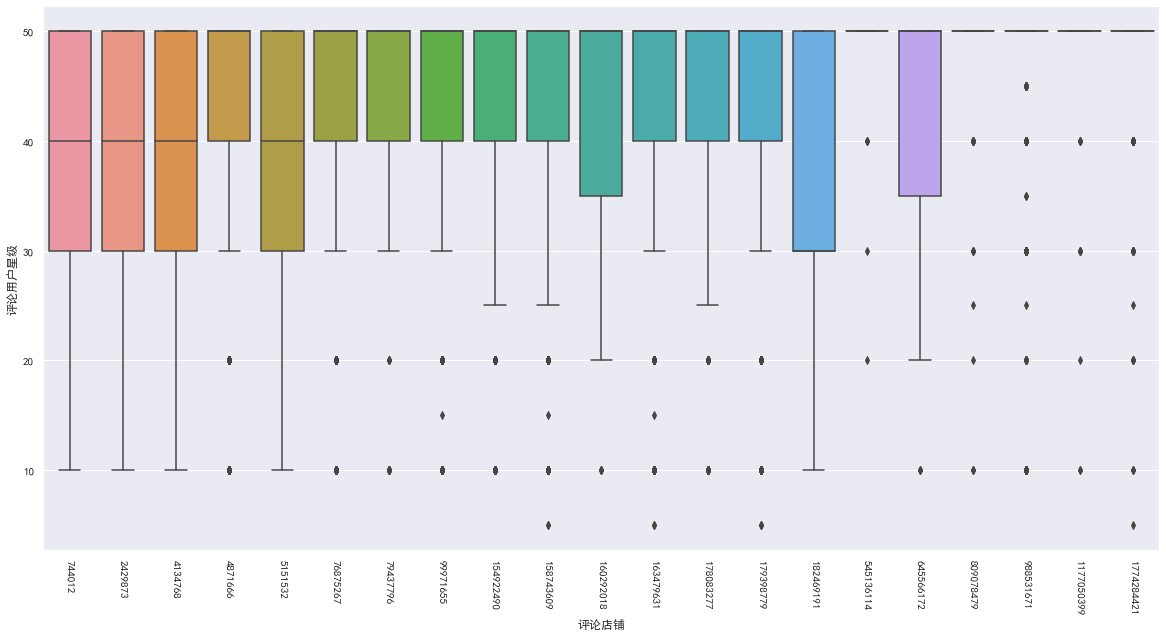

In [121]:
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=meituan,y='评论用户星级', x='评论店铺')
ax.set_xticklabels(ax.get_xticklabels(), rotation=-90)

keyi

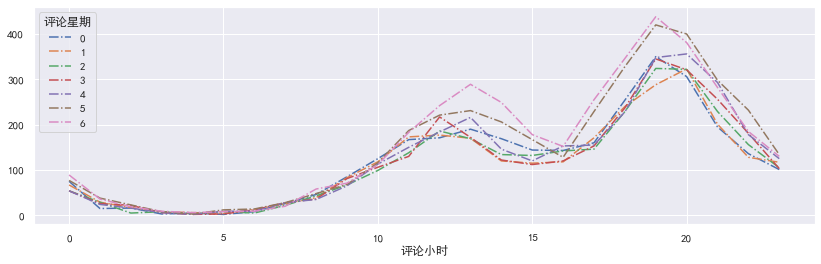

In [123]:
#各星期的小时评论数分布图
fig1, ax1= plt.subplots(figsize=(14,4))
df = meituan.groupby(['评论小时', '评论星期']).count()['评论店铺'].unstack()
df.plot(ax=ax1, style='-.')
plt.show()

d:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='评论用户星级', ylabel='评论长度'>

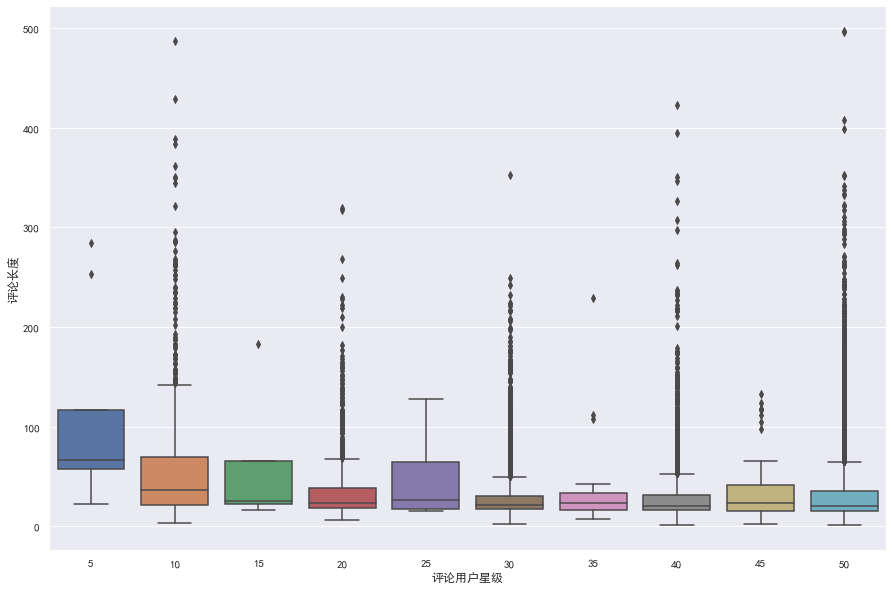

In [129]:
#评论的长短可以看出评论者的认真程度
meituan['评论长度'] = meituan['评论用户内容'].str.len()
fig2, ax2 = plt.subplots(figsize=(15,10))
sns.boxplot(x='评论用户星级',y='评论长度',data=meituan, ax=ax2)

接下来分析评论内容，对中文文本数据进行处理，我们使用jieba库，

In [148]:
meituan['评论用户内容'] = meituan['评论用户内容'].apply(lambda x: ' '.join(jieba.cut(x)))

d:\python\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


**去除停用词**：文本中有很多无效的词，比如“着”，“和”，还有一些标点符号，这些我们不想在文本分析的时候引入，因此需要去掉，因为wordcloud和TF-IDF都支持停用词，因此就不额外处理了

In [149]:
from wordcloud import WordCloud, STOPWORDS #导入模块worldcloud
from PIL import Image #导入模块PIL(Python Imaging Library)图像处理库
import numpy as np #导入模块numpy，多维数组
import matplotlib.pyplot as plt #导入模块matplotlib，作图
import matplotlib

In [150]:
infile = open("stopwords.txt",encoding='utf-8')
stopwords_lst = infile.readlines()
STOPWORDS = [x.strip() for x in stopwords_lst]
stopwords = set(STOPWORDS) #设置停用词

In [151]:
def ciyun(shop_ID='all'):
    texts = meituan['评论用户内容'] 
    if shop_ID == 'all':
        text = ' '.join(texts)
    else:
        text = ' '.join(texts[meituan['评论店铺'] == shop_ID])
    
    wc = WordCloud(font_path="msyh.ttc",background_color = 'white',max_words = 100,stopwords = stopwords,
                   max_font_size = 80,random_state =42,margin=3) #配置词云参数
    wc.generate(text) #生成词云
    plt.imshow(wc,interpolation="bilinear")#作图
    plt.axis("off") #不显示坐标轴

In [152]:
meituan['评论店铺'].unique()

array([ 158743609,  179398779,  645566172,  178083277,  809078479,
         99971655,    5151532,    2429873,     744012,    4871666,
          4134768,  163479631,  154922490,  988531671, 1774284421,
        182469191,   76875267,  160292018, 1177050399,   79437796,
        545136114], dtype=int64)

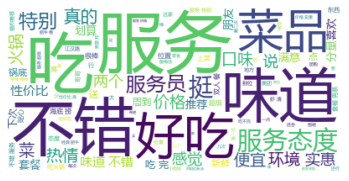

In [153]:
ciyun(158743609)

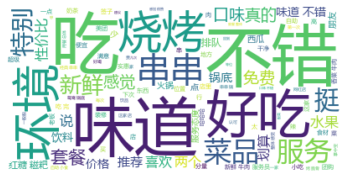

In [154]:
ciyun(179398779)

In [156]:
meituan.to_excel('meituan_preprocess.xlsx',index=False)